# Projeto 2 - Processamento de Imagens
## Técnicas de Visão Computacional e DALL-E

## 1. Carga e Instalação de pacotes

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.13


In [2]:
# Pacote do open CV
# https://opencv.org/
# https://pypi.org/project/opencv-python/
!pip install -q opencv-python==4.7.0.68

In [3]:
# Importa dos funções

# Importa pacote CV
import cv2

# Manipulação e visualização de dados
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Projeto 2 - Processamento de Imagens" --iversions

Author: Projeto 2 - Processamento de Imagens

matplotlib: 3.5.2
cv2       : 4.7.0
numpy     : 1.21.5



In [5]:
# Função customizada para visualizar as imagens
def visualiza_imagem(*args, figsize = 8, to_rgb = True, title = None, fontsize = 10):
    
    # Ajusta o tamanho da imagem
    if isinstance(figsize, int):
        figsize = (figsize, figsize)
    
    # Lista com todas as imagens passadas como argumento
    images = args[0] if type(args[0]) is list else list(args)
    
    # Converteremos as imagens para RGB
    if to_rgb:
        images = list(map(lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB), images))
    
    # Cada imagem deverá ter um título
    if title is not None:
        assert len(title) == len(images), "Forneça um título para a imagem."
    
    # Tamanho da figurea
    plt.figure(figsize = figsize)
    
    # Cria os subplots para imprimir as imagens
    for i in range(1, len(images) + 1):
        plt.subplot(1, len(images), i)
        if title is not None:
            plt.title(title[i - 1], fontsize = fontsize)
        plt.imshow(images[i - 1])
        plt.axis('off')

## 2. Histograma de Imagem

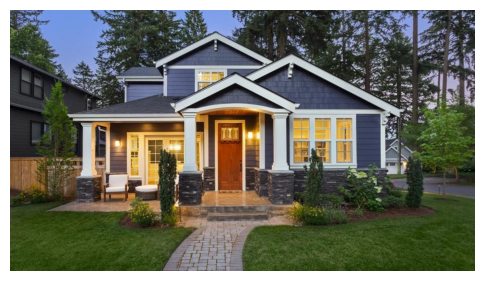

In [6]:
# Carrega e visualiza a imagem
img9 = cv2.imread('imagens/img9.jpg')
visualiza_imagem(img9, figsize = 6)

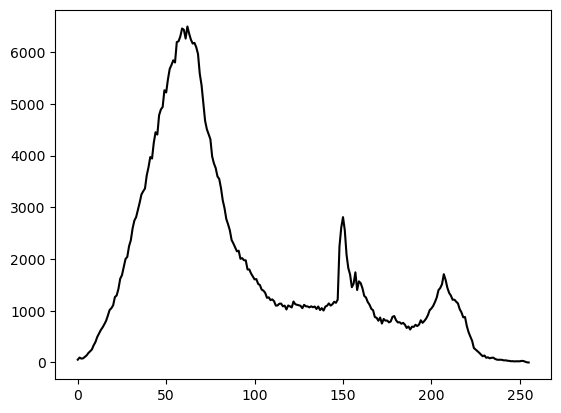

In [7]:
# Cria o histograma para um dos canais de cores, no caso uma imagem em preto e branco
gray_image = cv2.cvtColor(img9, cv2.COLOR_BGR2GRAY)
histogram = cv2.calcHist([gray_image], [0], None, [256], [0, 256])
plt.plot(histogram, color = 'k')
plt.show()

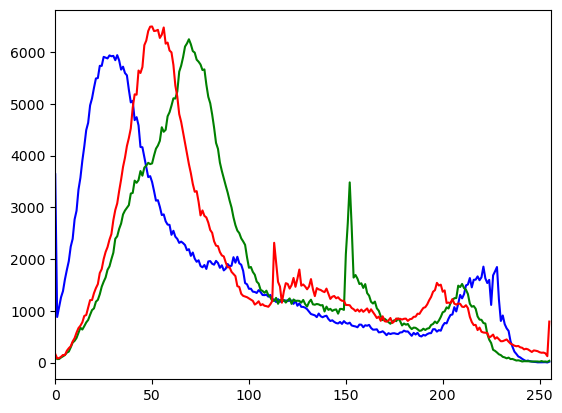

In [8]:
# Cria o histograma para cada um dos canais de cores 
for i, col in enumerate(['b', 'g', 'r']):
    hist = cv2.calcHist([img9], [i], None, [256], [0, 256])
    plt.plot(hist, color = col)
    plt.xlim([0, 256])
    
plt.show()

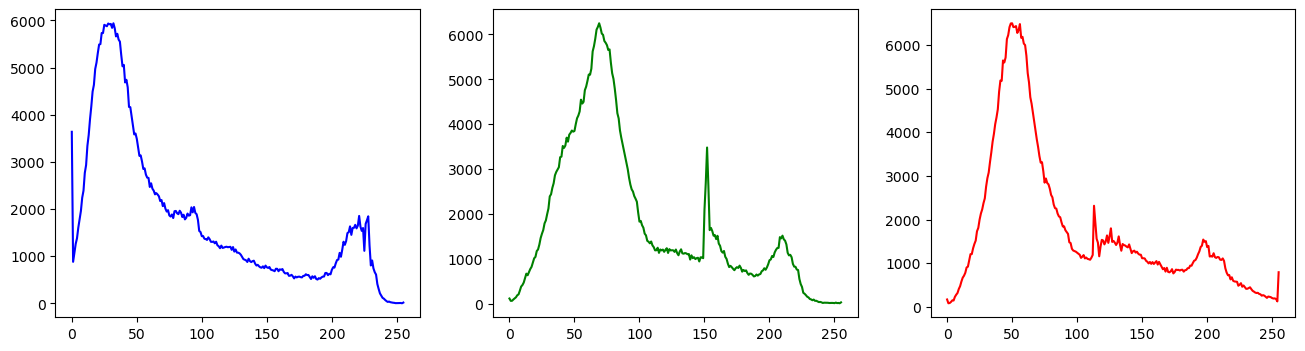

In [9]:
# Histograma de imagem separados por canal de cor
plt.figure(figsize=(16, 4))

hist_b, _ = np.histogram(img9[:,:,0], 256, (0, 255))
plt.subplot(1, 3, 1)
plt.plot(list(range(256)), hist_b, color='blue')

hist_g, _ = np.histogram(img9[:,:,1], 256, (0, 255))
plt.subplot(1, 3, 2)
plt.plot(list(range(256)), hist_g, color='green')

hist_r, _ = np.histogram(img9[:,:,2], 256, (0, 255))
plt.subplot(1, 3, 3)
plt.plot(list(range(256)), hist_r, color='red')

plt.show()

## 3. Equalização de Histograma

In [10]:
# Carrega a imagem na escala de cinza
img9 = cv2.imread('imagens/img9.jpg', cv2.IMREAD_GRAYSCALE)

In [11]:
# Equaliza o histograma da imagem com escala de cinza (1 canal de cor)
equ = cv2.equalizeHist(img9)

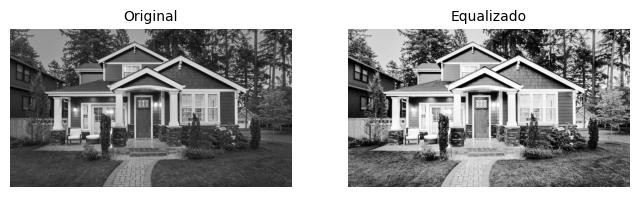

In [12]:
# Visualiza imagem original e com a equalização do histograma
visualiza_imagem(img9, equ, title = ['Original', 'Equalizado'])

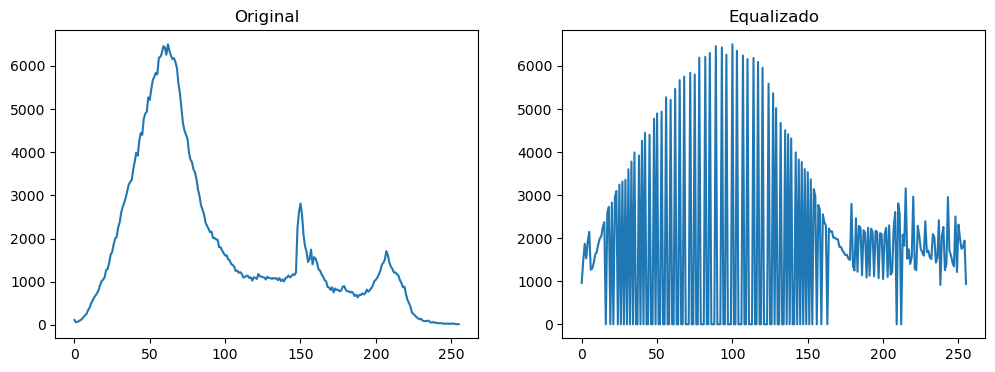

In [13]:
# Plot dos histogramas
plt.figure(figsize = (12, 4))

hist1, _ = np.histogram(img9, 256, (0, 255))
plt.subplot(1, 2, 1)
plt.title('Original')
plt.plot(list(range(256)), hist1)

hist2, _ = np.histogram(equ, 256, (0, 255))
plt.subplot(1, 2, 2)
plt.title('Equalizado')
plt.plot(list(range(256)), hist2)

plt.show()

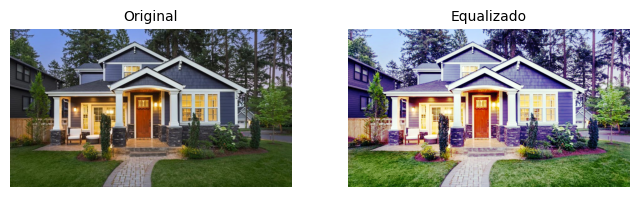

In [14]:
# Equalização de cada canal de cor
img9 = cv2.imread('imagens/img9.jpg')
equ = img9.copy()
equ[:, :, 0] = cv2.equalizeHist(img9[:, :, 0])
equ[:, :, 1] = cv2.equalizeHist(img9[:, :, 1])
equ[:, :, 2] = cv2.equalizeHist(img9[:, :, 2])
visualiza_imagem(img9, equ, title=['Original', 'Equalizado'])

## 4. Combinação de Histogramas de Imagens

In [15]:
# Função que combina histogramas de diferentes imagens
def combina_hist(source, template):
    
    # Shape original
    oldshape = source.shape
    
    # Shape modificado
    source = source.ravel()
    
    # Template
    template = template.ravel()

    # Retorna valores únicos da imagem de origem
    s_values, bin_idx, s_counts = np.unique(source, return_inverse = True, return_counts = True)
    
    # Retorna valores únicos da imagem de template
    t_values, t_counts = np.unique(template, return_counts = True)

    # Calculamos a soma das contagens e normalizamos pelo número de pixels para
    # obter as funções de distribuição cumulativa para a fonte e template (mapeia o valor do pixel --> quantil)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # Interpolação linear para encontrar os valores de pixel na imagem template
    # que correspondem mais de perto aos quantis na imagem de origem
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)
    interp_t_values = interp_t_values[bin_idx].reshape(oldshape)
    img = interp_t_values.astype('uint8')
    
    return img

Basicamente a técnica utilizada para a combinação de histogramas é a interpolação linear. Em resumo, a técnica  projeta valores entre pontos de dados no gráfico X e Y. Com um ponto inicial e final, é traçado uma reta entre os pontos e podemos supor qual seria os novos valores a partir da linha reta, por isso interpolação linear.

https://pt.wikipedia.org/wiki/Interpola%C3%A7%C3%A3o_linear

In [16]:
# Carrega as imagens
img9 = cv2.imread('imagens/img9.jpg', cv2.IMREAD_GRAYSCALE)
img10 = cv2.imread('imagens/img10.jpg', cv2.IMREAD_GRAYSCALE)

In [17]:
# Combinação dos histogramas
resultado = combina_hist(img9, img10)

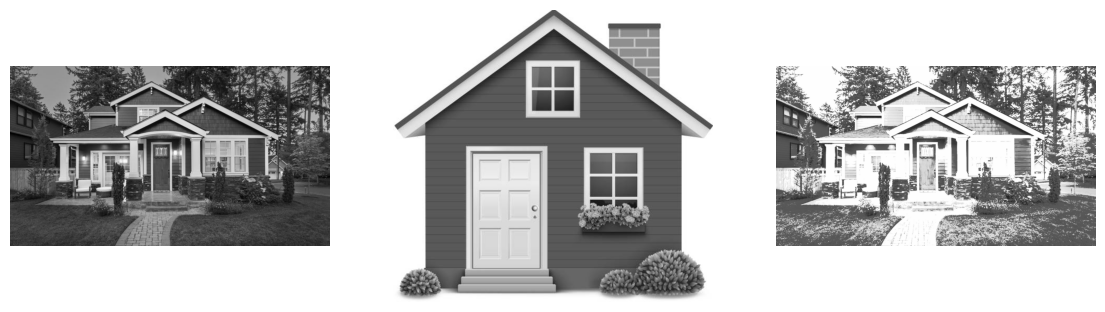

In [18]:
# Visualiza as imagens
visualiza_imagem(img9, img10, resultado, figsize = 14)

## 5. PDF (Probability Density Function) e CDF (Cumulative Distribution Function)

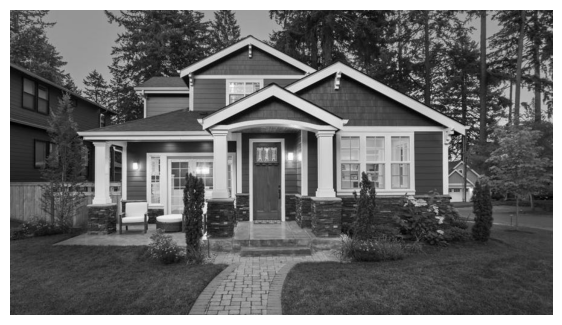

In [19]:
# Carrega e visualiza a imagem em escala de cinza
img9 = cv2.imread('imagens/img9.jpg', cv2.IMREAD_GRAYSCALE)
visualiza_imagem(img9, figsize = 7)

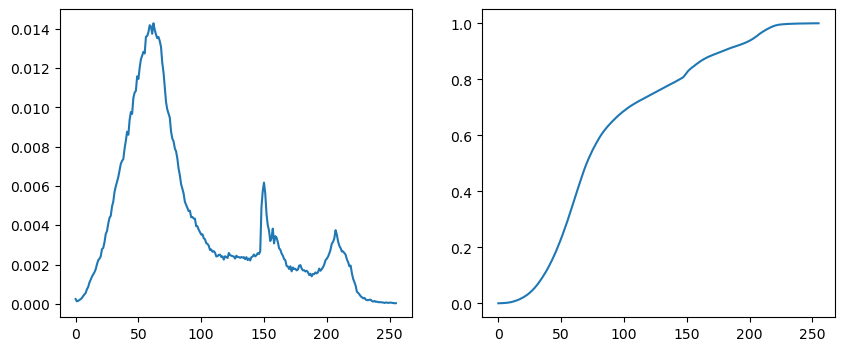

In [20]:
# Plot
plt.figure(figsize = (10, 4))

# Histograma
hist, _ = np.histogram(img9, 256, (0, 255))

# PDF
pdf = hist.astype('float32') / (img9.shape[0] * img9.shape[1])

# Plot
plt.subplot(1, 2, 1)
plt.plot(list(range(256)), pdf)

# Loop para criar a CDF
cdf = np.zeros_like(pdf)
for i in range(len(pdf)):
    cdf[i] = pdf[:i+1].sum()
    
# Plot
plt.subplot(1, 2, 2)
plt.plot(list(range(256)), cdf)

plt.show()

Histogram acima é de probabilidade, que á a representação gráfica da probabilidade do de um valor estar representado no eixo X. Já o CDF é a probabilidade acumulada do histograma. Todos os valores somados precisam ser 1 no final.

## 6. Box Filter

In [ ]:
# Carrega a imagem
img10 = cv2.imread('imagens/img10.jpg', cv2.IMREAD_GRAYSCALE)

In [ ]:
# Box filter
images = [img10]
titles = ['Original']
for k in [5, 11, 23, 51]:
    kernel = np.ones((k,k), dtype='uint8') / (k*k)
    out = cv2.filter2D(img10, -1, kernel)
    images.append(out)
    titles.append(f'{k}*{k} Box')

In [ ]:
visualiza_imagem(images, title = titles, figsize = 18)

Lembre-se que quanto menor os detalhes da imagem, melhor o processamento porque são menos pixels para analisar. Por isso é comum usar técnicas para "reduzir" a qualidade de uma imagem, na visão do analista, mas na visão da máquina isso é excelente.